In [20]:
from __future__ import print_function, division
import scipy
import glob
from keras.datasets import mnist
from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
from data_loader import DataLoader
import numpy as np
import os

In [21]:
class Pix2Pix():
    def __init__(self):
        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = 'train'
        dataset_name_t = self.dataset_name + "/White"
        

        self.train_data_loader = DataLoader(dataset_name= dataset_name_t, img_res=(self.img_rows, self.img_cols))
        dataset_name_t = self.dataset_name + "/Real"
        self.label_data_loader = DataLoader(dataset_name= dataset_name_t, img_res=(self.img_rows, self.img_cols))
        self.test_data_loader = DataLoader(dataset_name="test", img_res=(self.img_rows, self.img_cols))
        
        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 4
        self.df = 4

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generator
        #-------------------------

        # Build the generator
        self.generator = self.build_generator()
        
        # Input images and their conditioning images
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # By conditioning on B generate a fake version of A
        fake_A = self.generator(img_B)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminators determines validity of translated images / condition pairs
        valid = self.discriminator([fake_A, img_B])

        self.combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
        self.combined.compile(loss=['mse', 'mae'], loss_weights=[1, 100], optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        d7 = conv2d(d6, self.gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='sigmoid')(u7)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, self.df, bn=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model([img_A, img_B], validity)

    def train(self, epochs, batch_size=1):
        all_d_loss = np.zeros(epochs)
        all_g_loss = np.zeros(epochs)
        start_time = datetime.datetime.now()
        
        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)
        
        #  Train Discriminator
        for epoch in range(0, epochs):
            narray_imgsB_t = self.train_data_loader.load_batch(batch_size)
            
            narray_imgsB = list(narray_imgsB_t)
            
            for batch_i, imgs_A in enumerate(self.label_data_loader.load_batch(batch_size)):
                imgs_B = narray_imgsB[batch_i]
#                 imgs_B = imgs_B[:,:,:,:1]
#                 imgs_A = imgs_A[:,:,:,:1]
#                 ss = imgs_A[0].reshape((128, 128))
#                 print(ss.shape)
                
#                 plt.imshow(ss)
#                 break

                # Condition on B and generate a translated version
                fake_A = self.generator.predict(imgs_B)
                
                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = self.discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = self.discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                
                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])
                    
                elapsed_time = str(datetime.datetime.now() - start_time)
            all_d_loss[epoch] = d_loss[0]
            all_g_loss[epoch] = g_loss[0]
            print_out = (epoch, epochs, d_loss[0], 100*d_loss[1], g_loss[0],elapsed_time.split(".")[0])
            print ("[Epoch %d/%d]  [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % print_out)
        np.savetxt("all_d_loss.txt", all_d_loss, delimiter=",")
        np.savetxt("all_g_loss.txt", all_g_loss, delimiter=",")


In [22]:
if __name__ == '__main__':
    gan = Pix2Pix()
#     gan.discriminator.summary()
#     gan.combined.summary()

In [33]:
    gan.train(epochs= 10, batch_size= 1)

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 0/10]  [D loss: 0.017508, acc: 100%] [G loss: 8081.854492] time: 0:00:08
[Epoch 1/10]  [D loss: 0.015849, acc: 100%] [G loss: 8081.860840] time: 0:00:15
[Epoch 2/10]  [D loss: 0.014464, acc: 100%] [G loss: 8081.866211] time: 0:00:23
[Epoch 3/10]  [D loss: 0.013232, acc: 100%] [G loss: 8081.872559] time: 0:00:32
[Epoch 4/10]  [D loss: 0.012176, acc: 100%] [G loss: 8081.877930] time: 0:00:40
[Epoch 5/10]  [D loss: 0.011241, acc: 100%] [G loss: 8081.882812] time: 0:00:48
[Epoch 6/10]  [D loss: 0.010332, acc: 100%] [G loss: 8081.887695] time: 0:00:57
[Epoch 7/10]  [D loss: 0.009526, acc: 100%] [G loss: 8081.891113] time: 0:01:04
[Epoch 8/10]  [D loss: 0.008740, acc: 100%] [G loss: 8081.894531] time: 0:01:12
[Epoch 9/10]  [D loss: 0.008089, acc: 100%] [G loss: 8081.897949] time: 0:01:20


In [34]:
    imgs_test = gan.test_data_loader.load_data()
#     imgs_test = imgs_test[:,:,:,:1]
    fake_A = gan.generator.predict(imgs_test)
    gen_imgs = np.concatenate([fake_A])
#     gen_imgs = 0.5 * gen_imgs

In [35]:
    ids = 0
    for img in gen_imgs:
        plt.imsave("res_images/test_res_" + str(ids) + ".jpg", img)
        ids += 1                  
    plt.close()   
    print("test_data generator predict over.")

test_data generator predict over.


(10,) 10


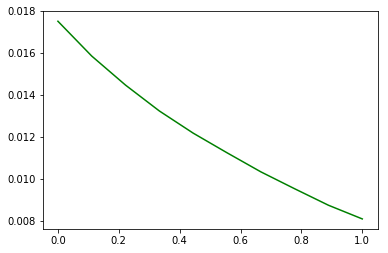

In [36]:
# draw loss 
all_d_loss_txt = np.loadtxt("all_d_loss.txt")
all_g_loss_txt = np.loadtxt("all_g_loss.txt")

print( all_d_loss_txt.shape, all_d_loss_txt.shape[0])
# print(all_g_loss_txt, all_g_loss_txt.shape, all_g_loss_txt.shape[0])

fig = plt.figure()
ax = plt.axes()
all_d_loss_x = np.linspace(0, 1, all_d_loss_txt.shape[0])
all_g_loss_x = np.linspace(0, 1, all_g_loss_txt.shape[0])

# plt.plot(all_g_loss_x, all_g_loss_txt, '-r');  # dotted red, g_loss
plt.plot(all_d_loss_x, all_d_loss_txt, '-g');  # dotted green, d_loss

plt.show()

In [27]:
#     gan.sample_images(20, 1)

In [28]:
# ss = np.array([1,2,3])
# ss[1]